In [5]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.evaluation import *
from decode_fish.funcs.plotting import *
from torch.utils.data import DataLoader
from decode_fish.funcs.routines import *
import seaborn as sns

import ipyvolume as ipv
import h5py

In [31]:
basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/'
data_dirs = ['sim_density_fac05_1','sim_density_fac1_1','sim_density_fac2_1']

axis_names = {'jaccard':'detection accuracy (JI) %', 'rmse_vol':'localization error (nm)', 'rmse_lat':'lateral localization error (nm)', 'rmse_ax':'axial localization error (nm)', 'group_p':'N groups / N localizations','eff_3d':'3D efficiency','recall':'recall %', 'precision':'precision %'}

In [105]:
total_dict = {'FISH-quant':{}, 'DECODE':{}}
snrs = ['High SNR','Medium SNR','Low SNR']
densities = [250,500,1000,2000,4000]

for i,d in enumerate(data_dirs):
    path = Path(basedir+d+'/fq_perf_dfs.pkl')
    if path.exists():
        with open(path, 'rb') as f:
            pdict = pickle.load(f)
        densities = pdict['densities']
        total_dict['FISH-quant'][snrs[i]] = pdict['gmm']
        
    path = Path(basedir+d+'/dec2_perf_dfs.pkl')
    if path.exists():
        with open(path, 'rb') as f:
            pdict = pickle.load(f)
        densities = pdict['densities']
        total_dict['DECODE'][snrs[i]] = pdict['dec']

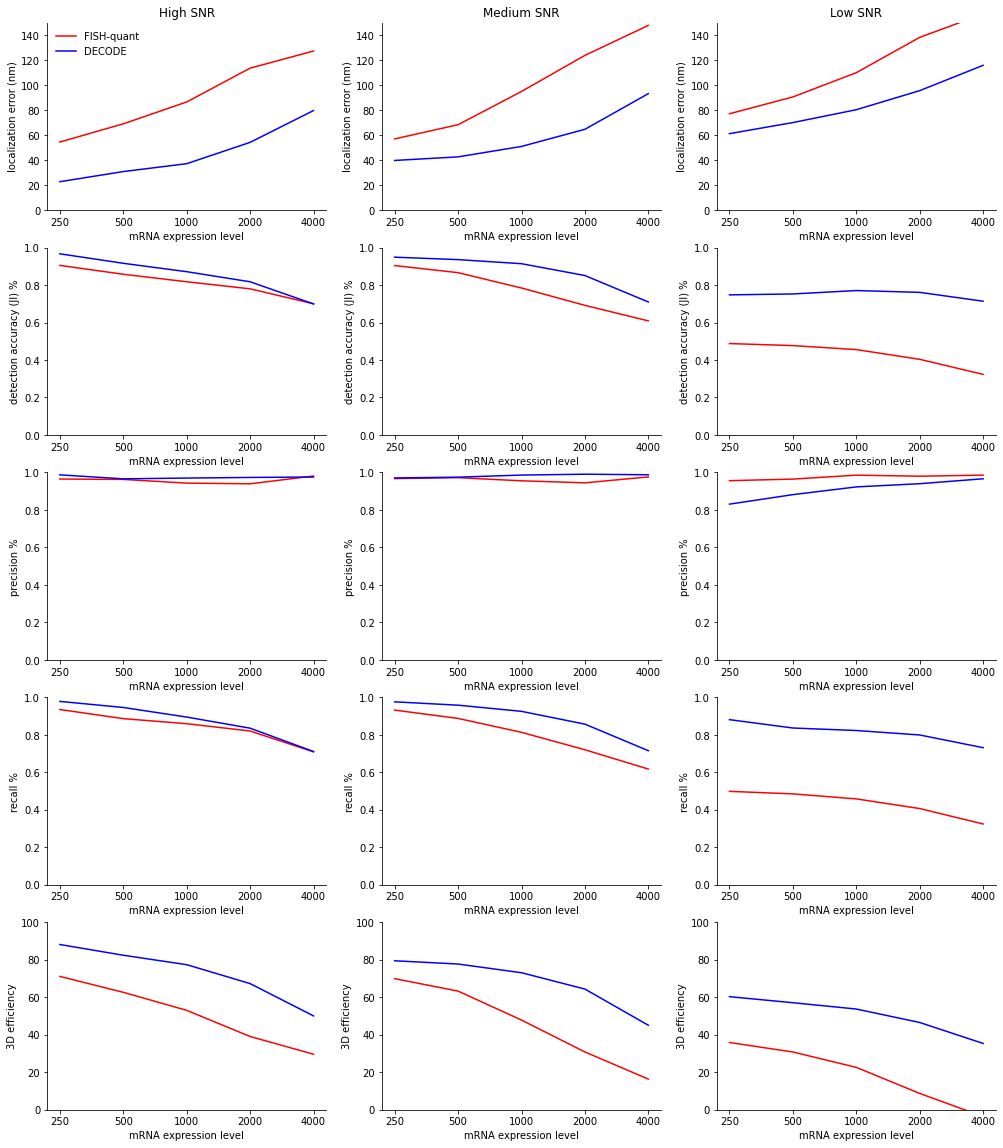

In [106]:
metrics = ['rmse_vol','jaccard','precision','recall','eff_3d']
algs = ['FISH-quant','DECODE']
alg_cols = {'FISH-quant':'red','DECODE':'blue'}
metric_lims = {'rmse_vol':[0,150],'jaccard':[0,1],'recall':[0,1],'precision':[0,1],'eff_3d':[0,100]}

plt.figure(figsize=(17,20))

for i,m in enumerate(metrics):
    for j,snr in enumerate(snrs):
        plt.subplot(len(metrics),3,j + i*3 + 1)

        for a in algs:
            if snr in total_dict[a]:
                plt.plot(np.arange(len(densities)), [d[m] for d in total_dict[a][snr]], label=a, color=alg_cols[a], linestyle='-')

        if i == 0 and j == 0:
            plt.legend(frameon=False)
        plt.ylabel(axis_names[m])
        plt.xlabel('mRNA expression level')
        plt.xticks(ticks=np.arange(len(densities)),labels=densities)
        plt.ylim(metric_lims[m])
        if i==0:
            plt.title(snr)
        sns.despine()

In [112]:
with h5py.File('../data/results/test_file.hdf5', 'r') as f:
    runs = list(f['microscope_state'].keys())
colors = sns.color_palette(n_colors=len(runs)+1)

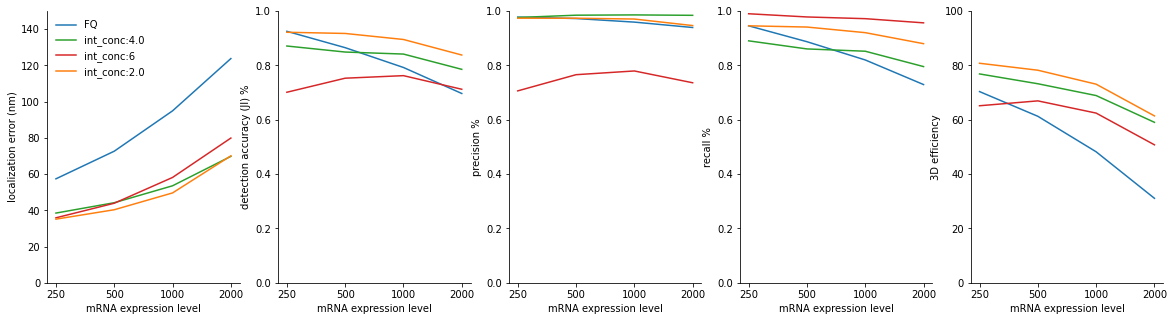

In [113]:
metrics = ['rmse_vol','jaccard','precision','recall','eff_3d']
alg_names = {'FISH-quant':'FQ','DECODE1':'int_conc:6.0','DECODE2':'int_conc:1.0'}
alg_cols = {'FISH-quant':colors[0]}
for i,r in enumerate(runs):
    alg_names[f'DECODE{i}'] = r
    alg_cols[f'DECODE{i}'] = colors[i+1]

metric_lims = {'rmse_vol':[0,150],'jaccard':[0,1],'recall':[0,1],'precision':[0,1],'eff_3d':[0,100]}
densities = [250,500,1000,2000]

plt.figure(figsize=(20,5))

with h5py.File('../data/results/test_file.hdf5', 'r') as f:

    for i,m in enumerate(metrics):
        plt.subplot(1,len(metrics),i+1)
        
        for n,k in alg_names.items():
            plt.plot(np.arange(len(densities)), [f['eval_densities'][str(d)][k]['performance'][m][()][0] for d in densities], label=alg_names[n], color=alg_cols[n], linestyle='-')

        if i == 0:
            plt.legend(frameon=False)
        plt.ylabel(axis_names[m])
        plt.xlabel('mRNA expression level')
        plt.xticks(ticks=np.arange(len(densities)),labels=densities)
        plt.ylim(metric_lims[m])

        sns.despine()

(0.0, 40.0)

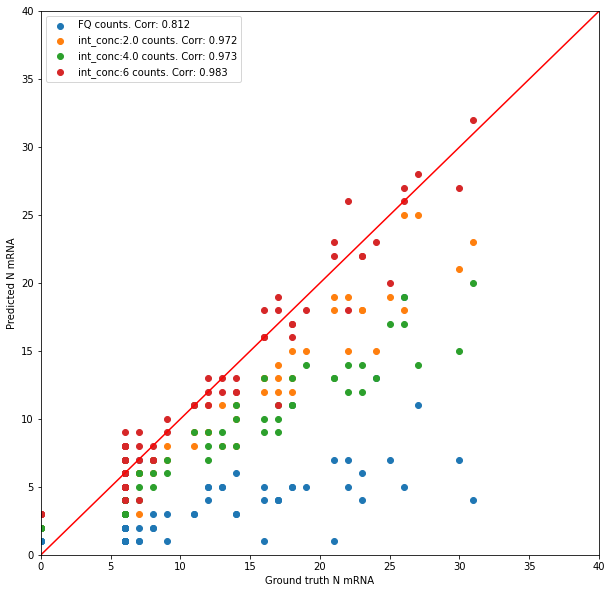

In [134]:
plt.figure(figsize=(10,10))

with h5py.File('../data/results/test_file.hdf5', 'r') as f:
    
    GT = f['eval_foci']['GT']['foci_counts'][()]
    
    for i,a in enumerate(f['eval_foci'].keys()):
        if a != 'GT':
            pred_count = f['eval_foci'][a]['foci_counts'][()]
            corr = np.round(np.corrcoef([GT, pred_count])[0,1],3)
            plt.scatter(GT, pred_count, label=f'{a} counts. Corr: {corr}', alpha=1.0)
            
plt.legend()
    
plt.plot([0,100],[0,100], 'red')
plt.xlabel('Ground truth N mRNA')
plt.ylabel('Predicted N mRNA')
plt.xlim(0,40)
plt.ylim(0,40)


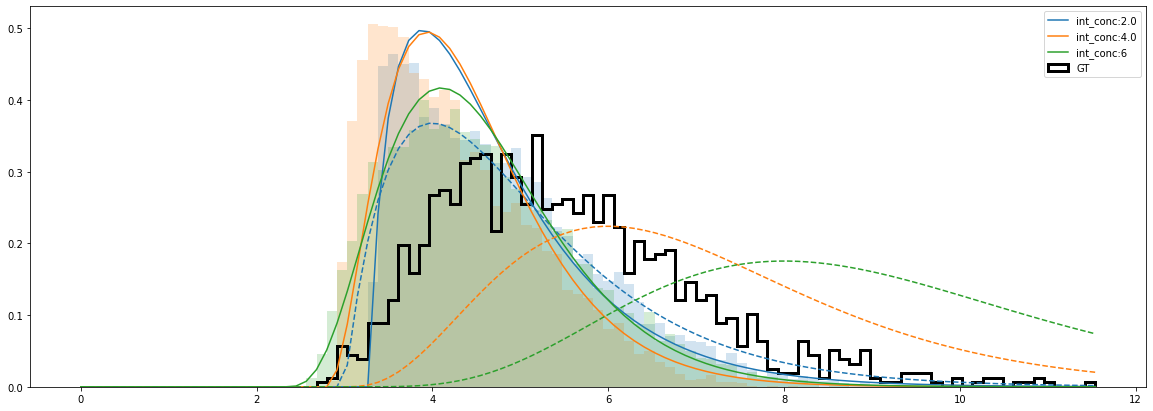

In [141]:
import scipy.stats as stats  

plt.figure(figsize=(20,7))

basedir = '/groups/turaga/home/speisera/share_TUM/FishSIM/sim_density_fac1_2/'
_, gt_df, _, _ = load_sim_fish(basedir, 2000, 'random', 'NR', 0)

gt_ints = gt_df['int']
int_max = gt_ints.max()
bins = np.linspace(0, int_max, 100)

_ = plt.hist(gt_ints, bins=bins, label='GT', color='black', linewidth=3, histtype='step', density=True)

with h5py.File('../data/results/test_file.hdf5', 'r') as f:
    
    colors = sns.color_palette(n_colors=len(f['microscope_state'].keys()))
    
    for i,m in enumerate(f['microscope_state'].keys()):
        
        g = f['microscope_state'][m]
        y_pre = stats.gamma.pdf(bins, g['conc_pre'][()], g['loc_pre'][()], 1/g['rate_pre'][()])
        plt.plot(bins, y_pre, linestyle='--', c=colors[i])
        
        y_post = stats.gamma.pdf(bins, g['conc_post'][()], g['loc_post'][()], 1/g['rate_post'][()])
        plt.plot(bins, y_post, label=m, c=colors[i])
        
        plt.hist(f['eval_densities']['2000'][m]['locations']['int']+g['loc_post'][()], density=True, bins=bins, color=colors[i], alpha=0.2)
        
plt.legend()